<p align = "center">
    <img src="https://blueedtech.com.br/wp-content/themes/blue/dist/images/logo-blue-croped.gif", width = "400em" />
</p>

In [1]:
import spacy

import pandas as pd

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import SVG, display,display_png 
import plotly.io as pio 

from sklearn.base import TransformerMixin 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.base import TransformerMixin 
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

spacy.prefer_gpu()

nlp = spacy.load('en_core_web_sm')

# Análise de dados

&nbsp;&nbsp;&nbsp;&nbsp;Os dados que serão estudados são frases que expressam um sentimento sobre o mercado financeiro, o dataset apresentando é uma pesquisa efetuada do FiQA e da *Financial PhraseBank* combinados dentro de um arquivo CSV.

| Nome | Descrição |
| :--- | :---|
|SENTENCE| Frase com sentimento entre negativo, neutro e positivo com sentimento  |
|SENTIMENT| Valor categórico entre negativo, neutro e positivo representando o sentimento expresso pela frase |


## Objetivos do projeto

&nbsp;&nbsp;&nbsp;&nbsp;O objetivo deste trabalho é realizar um modelo que é capaz de classificar as frases de acordo com os sentimentos apresentados

## Diretrizes do projeto

1. Estudo inicial dos dados
    1. Visualização dos dados
2. Manejamento dos dados
    1. Retirada de ruídos
    2. Verificação da necessidade de substituição de dados (caso necessário)
3. Estudo dos modelos
    1. Pré-processamento
    2. Modelos de regressão
    3. Modelos de classificação
    4. Analise de métricas (Apartir dessa etapa o projeto pode voltar etapas)
4. Conclusão do trabalho

## Formatação do projeto

&nbsp;&nbsp;&nbsp;&nbsp;O projeto apresentado irá responder as questões apresentadas pela Blue EdTech, das quais são:

1. Construa as funções e a pipeline, separe os dados em treino e teste, execute a pipeline para classificar em positivo, negativo e neutro. Quais foram os valores de acurácia, precisão e sensitividade deste modelo? (3.0 pontos)

2. Use o seu modelo para classificar os seguintes textos extraídos do site Financial Times. Faça uma tabela com o valor esperado e o valor obtido, e responda: houve divergência entre o esperado e o obtido? O que poderia ser feito para corrigir? (1.0 ponto)

**OBS**: Esta questão está com as palavras dentro de um arquivo chamado test.csv, do qual poderá ser analisado no decorrer do projeto.

3. Faça uma análise exploratória, onde identifique as três empresas mais citadas e quantifique os níveis de positividade, negatividade e neutralidade dos textos sobre estas empresas. (3.0 pontos) A. Extraia de todos os textos as entidades, há quantas entidades? (0.6 pontos) B. Quantas entidades são empresas? (0.6 pontos) C. Quais são as três empresas mais citadas? (0.6 pontos) D. Faça uma tabela onde demonstre as três empresas mais citadas e o total de textos positivos, negativos e neutros de cada uma. (1.2 pontos)

4. Faça gráficos a partir da tabela obtida acima. Descreva cada gráfico de forma que estivesse apresentando à diretoria dessas três empresas. (3.0 pontos) 

### Construa as funções e a pipeline, separe os dados em treino e teste, execute a pipeline para classificar em positivo, negativo e neutro. Quais foram os valores de acurácia, precisão e sensitividade deste modelo?

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/AugustoCRX/Blue/main/Blue/modulo3/proj3/data.csv')
# df = pd.read_csv('data.csv') caso haja problema com o link acima

&nbsp;&nbsp;&nbsp;&nbsp;Esse dataframe apresenta uma série de dados duplicados, então existe a necessidade de visualização de como esses dados estão apresentados.

In [3]:
duplicates = df[df.duplicated(subset=['Sentence'], keep=False)]

In [4]:
duplicates.value_counts('Sentiment')

Sentiment
neutral     526
negative    514
dtype: int64

In [5]:
df.value_counts('Sentiment')

Sentiment
neutral     3130
positive    1852
negative     860
dtype: int64

&nbsp;&nbsp;&nbsp;&nbsp;Como é possível a visualização, existem muitos dados duplicados e existe um desbalanceamento dos dados em relação a todas as variáveis, e os valores duplicados são predominantemente neutros e negativos e para não desbalancear mais o *data set*, serão retirados os valores duplicados neutros do data set.

In [6]:
df = df.sort_values(by = 'Sentiment').reset_index(drop = True).drop_duplicates(subset=['Sentence'], keep='first').reset_index(drop=True)

In [7]:
#Definição das classes de limpeza do texto
class predictors (TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]
    def fit(self, X, y=None, **fit_params):
        return self
    def get_params(self, deep=True):
        return {}

# Esta funcao remove espacos em branco no inicio e no fim do texto e converte todo o texto em letras minusculas
def clean_text(texto):
    return texto.strip().lower()

#Esta função seleciona os caracteres que serão selecionados
#Token significa um item da nlp, por exemplo, 'Bom dia' possui dois tokens, 'Bom' e 'dia'.
#is_stop checa se o token é uma stopword (stopwords são definidas como palavras que não possuem importância para o modelo, como por exemplo, preposições, pronome e dentre outros)
#is_punct checa se o token é uma pontuação
#is_space checa se o token possui algum espaço em branco
#like_url checa se o token possui alguma semelhança com alguma url
#is_bracket checa se o token é '[]'
#is_left_punct e is_right_punct checa se o valor possui ( ou ), respectivamente
def tokenizer(texto):
    doc = nlp(texto)
    tokens = [token for token in doc if ((not token.is_stop) & (not token.is_punct) & (not token.is_space) & (not token.is_quote) & (not token.like_url) & (not token.is_bracket) & (not token.is_left_punct) & (not token.is_right_punct))]
    tokens = [token.lemma_.lower().strip() for token in tokens]
    return tokens

#variável responsável por executar o vetor de limpeza dos tokens
vector = CountVectorizer(tokenizer=tokenizer, ngram_range=(1,1))

In [8]:
#classe responsável por treinamento do modelo e seleção de variáveis
class model_train_and_choice():
    #A primeira função é responsável por treinamento do modelo
    #Condições obrigatórias para funcionamento da função:
    # X e y
    #Condições opcionais:
    # model - essa opção recebe os valores de 'KNN', 'Ada Boost', 'SVM', ela é facultativa, pois caso não seja definido modelo ela irá testar os 3 modelos, caso haja definição,
    # ela irá executar apenas o modelo escolhido. Vale destacar que caso seja especificado a função ele retorna tanto as métricas quanto o pipeline, caso não seja especificado 
    # ele executa as 3 funções e retorna apenas as métricas. 
    # random_st - é o parâmetro random_state da função train_test_split
    # test_sz - é o parâmetro test_size da função train_test_split
    def train_model(self, X, y, model=None, random_st = 10, test_sz = 0.2):
        X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=random_st, test_size=test_sz)
        metrics = {}
        model_sel = {
                    'KNN': KNeighborsClassifier(n_neighbors=3),
                    'Ada Boost': AdaBoostClassifier(base_estimator= LogisticRegression(), learning_rate = 1, n_estimators=100),
                    'SVM': SVC()
                    }
        #execução dos modelos caso não existe definição de modelo anteriormente
        if model == None:
            for i in model_sel:
                pipe = Pipeline([("cleaner", predictors()),
                    ('vectorizer', vector),
                    ('classifier', model_sel[i]),
                    ])
                print('Training model: {}'.format(i))
                pipe.fit(X_train, y_train)
                y_pred = pipe.predict(y_test)
                metrics[i] = ([accuracy_score(y_test, y_pred),precision_score(y_test, y_pred, average='macro', zero_division=0),recall_score(y_test, y_pred, average='macro')])
            return metrics
        #execução do modelo especificado
        else:
            pipe = Pipeline([("cleaner", predictors()),
                    ('vectorizer', vector),
                    ('classifier', model_sel[model]),
                    ])
            print('Training model: {}'.format(model))
            pipe.fit(X_train, y_train)
            y_pred = pipe.predict(y_test)
            #o parâmetro zero_division é um parâmetro determinador que caso exista uma divisão por zero na definição do precision_score, ela seja substituida por 0, isso acontece 
            # pois já que o dataframe possui 3 valores de categorias o valor da precisão será dado por tp/(tp+fp), todavia caso tp + fp seja igual a 0, pode-se considerar 2 opções:
            # ou substituir este valor especifico em 0,1 ou substituir por 0 e subir um erro avisando um erro de convergência utilizando o parâmetro "warn".
            metrics[model] = ([accuracy_score(y_test, y_pred),precision_score(y_test, y_pred, average='macro', zero_division=0),recall_score(y_test, y_pred, average='macro')])
            return metrics, pipe
    #função de seleção de melhor modelo.
    #já que existe 
    def best_model(self, metrics = list):
        mean_metrics = []
        for i in metrics:
            mean_metrics.append([i,(2*metrics[i][0]+metrics[i][1]+metrics[i][2])/4])
        results = max(mean_metrics, key=lambda x: x[1])
        return results

In [9]:
#definição do modelo inicial para seleção via métricas.
X = df['Sentence']
y = df['Sentiment']
model = model_train_and_choice()
results = model.train_model(X,y)
best_model = model.best_model(results)

Training model: KNN
Training model: Ada Boost
Training model: SVM


In [10]:
#apresentação dos resultados
print(f'Best model: {best_model[0]}')
print(f'Acurácia: {results[best_model[0]][0]*100:.02f}%')
print(f'Precisão: {results[best_model[0]][1]*100:.02f}%')
print(f'Sensibilidade {results[best_model[0]][2]*100:.02f}%')

Best model: SVM
Acurácia: 83.66%
Precisão: 58.36%
Sensibilidade 66.67%


Use o seu modelo para classificar os seguintes textos extraídos do site Financial Times. Faça uma tabela com o valor esperado e o valor obtido, e responda: houve divergência entre o esperado e o obtido? O que poderia ser feito para corrigir?

In [11]:
#definição da questão 2 do projeto.
test = pd.read_csv('https://raw.githubusercontent.com/AugustoCRX/Blue/main/Blue/modulo3/proj3/test.csv')
# test = pd.read_csv('test.csv') caso o link acima cause algum problema.
test.head()

,Sentiment,Sentence
0,negative,"Central banks’ rate rises, geopolitical risk a..."
1,neutral,China opens up bond market in bid to woo forei...
2,negative,HM Revenue & Customs says residents had £850bn...
3,negative,Japan’s horrifying crop of data falsification ...
4,neutral,"Despite internal problems, the group continues..."


In [12]:
#treinamento
pipeline = model.train_model(X,y, model ='SVM')[1]
X_test = test['Sentence']
y_pred = pipeline.predict(X_test)

Training model: SVM


In [13]:
#métrica de acurácia do conjunto de teste
acertou = []
for i in range(len(y_pred)):
    if y_pred[i] == test['Sentiment'][i]:
        acertou.append(1)
print('A acurácia é: ',(len(acertou)/len(y_pred))*100)

A acurácia é:  40.0


In [14]:
pd.concat((test['Sentiment'],pd.DataFrame(y_pred, columns = ['Predict_sentiment'])), axis = 1)

,Sentiment,Predict_sentiment
0,negative,positive
1,neutral,neutral
2,negative,neutral
3,negative,neutral
4,neutral,neutral


&nbsp;&nbsp;&nbsp;&nbsp;O modelo errou em 60% dos casos. É relativamente esperado que exista realmente um vício, como um *overfitting*, em relação às variáveis  neutras, porque ele está provavelmente viciado em classificar neutros e é esperado esse comportamento, pois quando se compara os casos que se tem no começo do projeto existe uma alta concentração de neutros em relação aos negativos e positivos, tanto que a decisão tomada acerca das instâncias duplicadas foi de retirar as que são neutras.

&nbsp;&nbsp;&nbsp;&nbsp;Existem duas soluções que podem ser tomadas acerca da base de dados utilizada. A primeira e recomendada é fazer o requerimento de mais dados negativos e positivos para que o algoritmo consiga entender melhor como que as frases negativas e positivas se comportam. A segunda seria fazer ou um oversampling ou um undersampling requerendo total conhecimento do que está acontecendo com essas adições ou subtrações, visto que é necessário que o algoritmo monte frases e com isso faça o julgamento entre negativo, neutro e positivo, existindo uma grande complexidade por trás do algoritmo.

&nbsp;&nbsp;&nbsp;&nbsp;Dentro da biblioteca da spacy, existem pacotes que determinam o nível de complexidade das sentenças, é possível utilizar outros pacotes mais robustos buscando melhores resultados.

3. Faça uma análise exploratória, onde identifique as três empresas mais citadas e quantifique os níveis de positividade, negatividade e neutralidade dos textos sobre estas empresas. 

A. Extraia de todos os textos as entidades, há quantas entidades? 

B. Quantas entidades são empresas? 

C. Quais são as três empresas mais citadas? 

D. Faça uma tabela onde demonstre as três empresas mais citadas e o total de textos positivos, negativos e neutros de cada uma.

In [15]:
# Criando um modelo de seleção de entidades
def entity_extractor(dataframe):
    entity = []
    for i in range(len(dataframe)):
        doc = nlp(dataframe['Sentence'][i])
        ent = [token.text for token in doc.ents]
        ent_type = [token.label_ for token in doc.ents]
        for qnt_ent in range(len(ent)):
            entity.append([clean_text(ent[qnt_ent]), ent_type[qnt_ent], dataframe['Sentiment'][i]])
    entity = pd.DataFrame(entity, columns = ['Sentence', 'Entity_Type', 'Sentiment'])
    return entity

In [16]:
#função regressiva para seleção de entidades do tipo organização
def entites_org(dataframe, loop=0):
    dataframe = dataframe.replace(r'[)($<@%+-]', '', regex=True).reset_index()
    global entity
    entity = entity_extractor(dataframe)
    orgs = entity.query('Entity_Type == "ORG"')
    if loop > 3:
      return orgs
    else:
      return entites_org(orgs, loop+1)

In [17]:
orgs_test = entites_org(df)

In [18]:
orgs = pd.crosstab(orgs_test['Sentence'], orgs_test['Sentiment'])
orgs['total'] = orgs.sum(axis=1)

In [19]:
print('O número total de entidades é:', entity.shape[0])
print('O número total de empresas é:', orgs.shape[0])  
print('As empresas mais citadas são:', orgs.sort_values(by='total', ascending=False).head(3).index[0:3].values)
print('O número de comentários negativos, neutros, positivos e totais é: \n\n', orgs.sort_values(by='total', ascending=False).head(3))

O número total de entidades é: 1140
O número total de empresas é: 637
As empresas mais citadas são: ['nokia' 'tesco' 'omx']
O número de comentários negativos, neutros, positivos e totais é: 

 Sentiment  negative  neutral  positive  total
Sentence                                     
nokia             6       54        30     90
tesco            11        3        15     29
omx               9       11         2     22


4. Faça gráficos a partir da tabela obtida acima. Descreva cada gráfico de forma que estivesse apresentando à diretoria dessas três empresas.

In [24]:
def grafico(figure = str): # figure é só um denominativo para especificação da organização
    fig = make_subplots(rows=1, cols=3, subplot_titles=('<b>Total absoluto</b>', '<b>Porcentagem</b>', '<b>Relação positivo versus negativo</b>'))

    #definição das cores para as barras do gráficos
    colors = {'negative': 'rgb(178,34,34)', 'neutral':'rgb(245,245,220)','positive' :'rgb(46,139,87)', 'total' :'rgb(119,136,153)'}
    #primeiro gráfico, esse gráfico abrange os valores absulutos de valores positivos, negativos, neutros e totais
    fig.add_trace(
                    go.Bar(y = orgs[orgs.index == figure].iloc[0].reindex(index=['negative','neutral','positive','total']),  
                    text =  orgs[orgs.index == figure].iloc[0].reindex(index=['negative','neutral','positive','total']),     
                    marker_color = (colors['negative'],colors['neutral'],colors['positive'],colors['total']),
                    marker_line_color='rgb(0,0,0)',
                    marker_line_width=1.5,
                    textfont=dict(
                                family="Droid Sans Mono",
                                size=18,
                                color="Black"
        )
                    ),
                    row = 1, col = 1)
    # atualiza os valores de x para não ficarem entre 0 e 3
    fig.update_xaxes(
                        tickvals = [0,1,2,3],
                        ticktext = ['Negativo', 'Neutro','Positivo', 'Total'],
                        row=1,col=1)
    # o segundo gráfico abrange a porcentagem de cada sentimento em relação ao total
    fig.add_trace(
                    go.Bar(y = ((orgs[orgs.index == figure].loc[figure, ['positive','neutral','negative']].reindex(index=['negative','neutral','positive']))/orgs[orgs.index == figure].iloc[0,3]),
                    text =  ((orgs[orgs.index == figure].loc[figure, ['positive','neutral','negative']].reindex(index=['negative','neutral','positive']))/orgs[orgs.index == figure].iloc[0,3]).round(2),      
                    marker_color = (colors['negative'],colors['neutral'],colors['positive']),
                    marker_line_color='rgb(0,0,0)',
                    marker_line_width=1.5,                    
                    textfont=dict(
                                    family="Droid Sans Mono",
                                    size=18,
                                    color="Black")
                    ), row = 1, col = 2).update_traces(textposition='outside')
    # atualiza os valores de x para não ficarem entre 0 e 3
    fig.update_xaxes(
                        tickvals = [0,1,2,3],
                        ticktext = ['Negativo', 'Neutro','Positivo', 'Total'],
                        row=1,col=2)
    # o terceiro gráfico abrange a relação positivo/negativo de cada sentimento em porcentagem
    fig.add_trace(
                    go.Bar(y = orgs[orgs.index == figure].loc[figure, ['positive','negative']].reindex(index=['negative','positive'])/(orgs[orgs.index == figure].loc[figure, 'negative'] + orgs[orgs.index == figure].loc[figure, 'positive']), 
                    text = round(orgs[orgs.index == figure].loc[figure, ['negative','positive']]/(orgs[orgs.index == figure].loc[figure, 'negative'] + orgs[orgs.index == figure].loc[figure, 'positive']),2),    
                    marker_color = (colors['negative'],colors['positive']),
                    marker_line_color='rgb(0,0,0)',
                    marker_line_width=1.5,                
                    textfont=dict(
                                family="Droid Sans Mono",
                                size=18,
                                color="Black"
                                ),
                    width = [0.5,0.5] # define o largura das barras
                    ),
                    row = 1, col = 3).update_traces(textposition='outside')

    fig.update_xaxes(
                        tickvals = [0,1],
                        ticktext = ['Negativo','Positivo'],
                        row=1,col=3,
                        ).update_yaxes(visible =False, mirror = True) # oculta o eixo y 

    fig.update_layout(
                        title_text=f'<b>{figure.title()}</b><br>' + 
                        f'<b>{figure.title()}<i> é uma marca registrada da</i> {figure.title()} Corp.</b> ',
                        width = 1200, height = 800,
                        paper_bgcolor = 'rgb(256,256,256)', # cor de fundo do papel do gráfico
                        plot_bgcolor = 'rgb(256,256,256)', # cor de fundo do gráfico
                        showlegend = False,
                        # esse código gera a divisão do gráfico em 3 partes
                        shapes=[
                                go.layout.Shape(
                                # define o tipo de divisão
                                type='rect', # tipo de divisão via retângulo (rectangle)
                                xref='paper', yref='paper', #referência do retângulo na tela
                                x0=0, y0=0, #posição inicial do retângulo
                                x1=1.05,y1=1, #posição final do retângulo
                                line={'width': 1, 'color': 'black'}), # define a cor e a largura da borda do retângulo
                                # define a primeira divisão do gráfico
                                go.layout.Shape(
                                type='line', # tipo de divisão via linha (line)
                                xref='paper', yref='paper',
                                x0=0.33, y0=0,
                                x1=0.33, y1=1,
                                line={'width': 1, 'color': 'black'}),
                                # define a segunda divisão do gráfico
                                go.layout.Shape(
                                type='line', # tipo de divisão via linha (line)
                                xref='paper', yref='paper',
                                x0=0.67, y0=0,
                                x1=0.67, y1=1,
                                line={'width': 1, 'color': 'black'})]),

    # adiciona uma logo ao gráfico
    fig.add_layout_image(
        dict(
            source='https://i.imgur.com/NVyVNNF.png',
            xref="paper", yref="paper",
            x=1.05, y=1.05,
            sizex=0.15, sizey=0.15,
            xanchor="right", yanchor="bottom" # define a origem do logo
        )
    )                            
    img_bytes = fig.to_image(format="png")
    return display_png((img_bytes), raw = True)

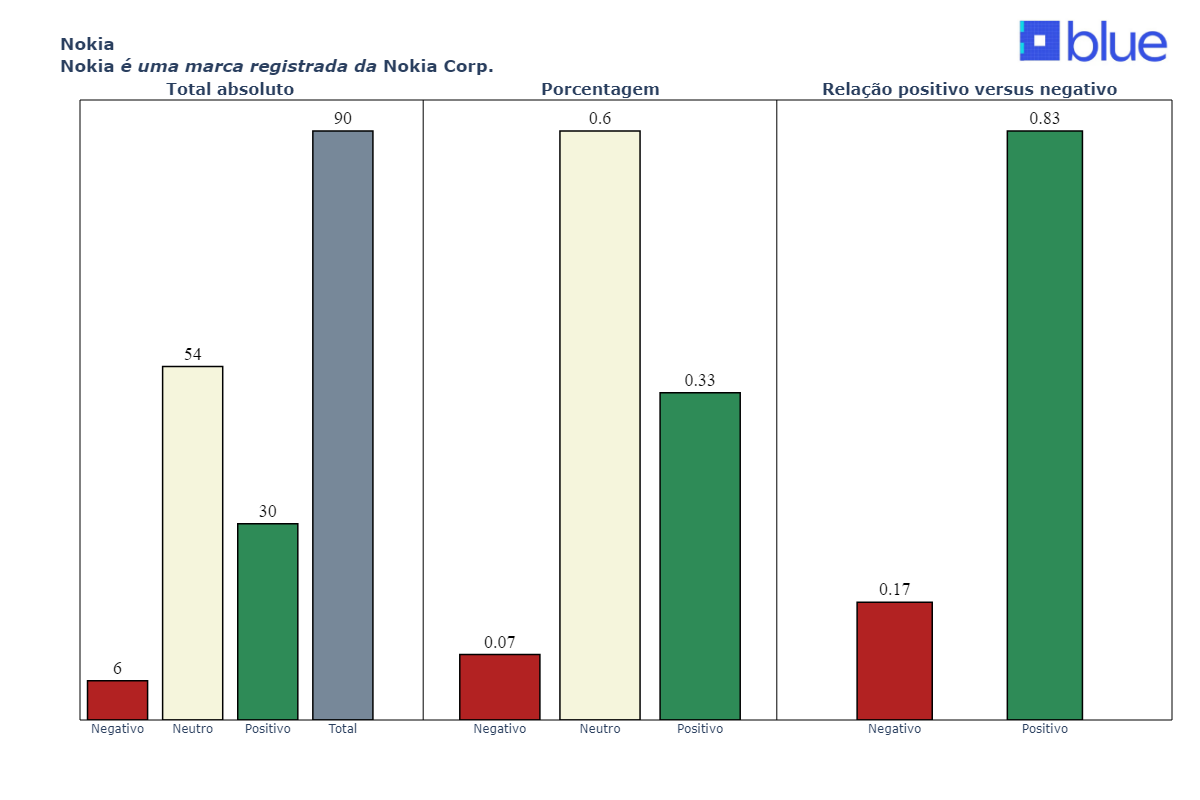

In [25]:
grafico('nokia')

&nbsp;&nbsp;&nbsp;&nbsp;É possível perceber que a Nokia está com um ótimo desempenho na internet, existem muitos clientes na neutralidade em relação à empresa, mas existem muitos clientes satisfeitos em relação aos clientes não satisfeitos

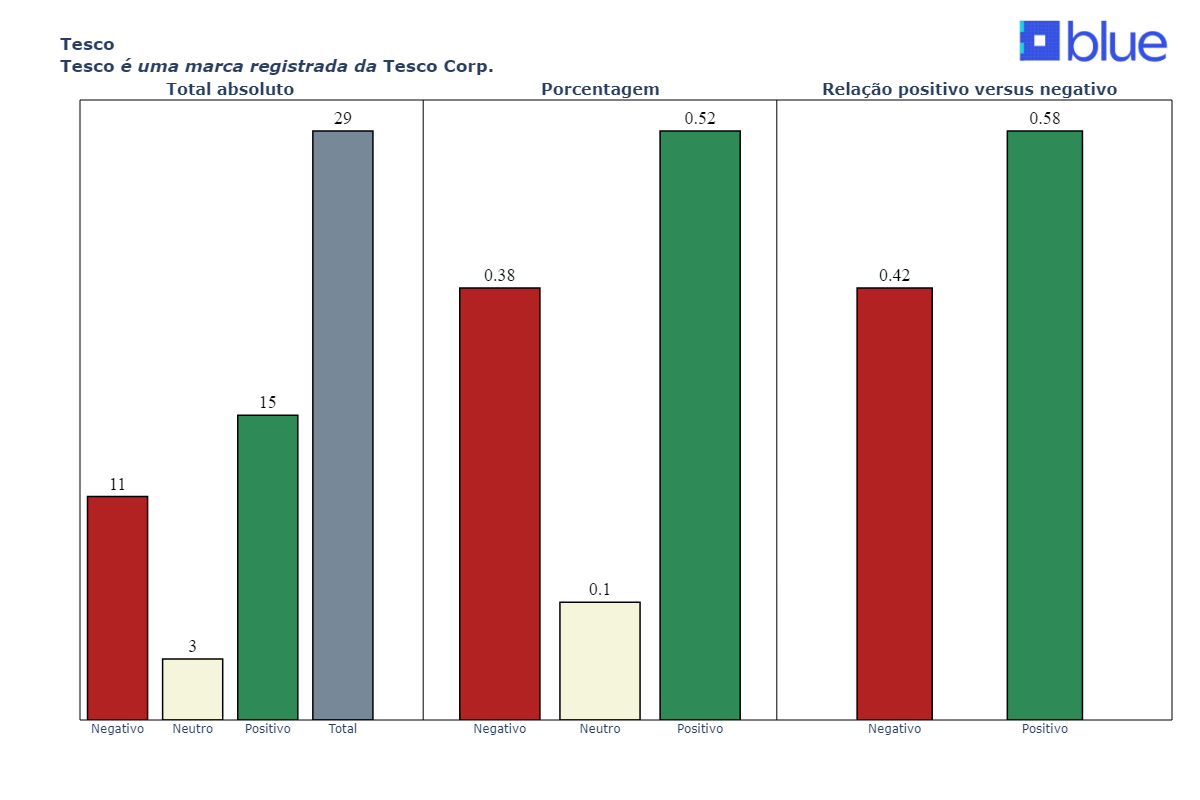

In [26]:
grafico('tesco')

&nbsp;&nbsp;&nbsp;&nbsp;A tesco está com um patamar de igualdade, existem poucos neutros, todavia existem muitos comentários negativos e positivos, pode-se dizer que estão praticamente equivalentes.

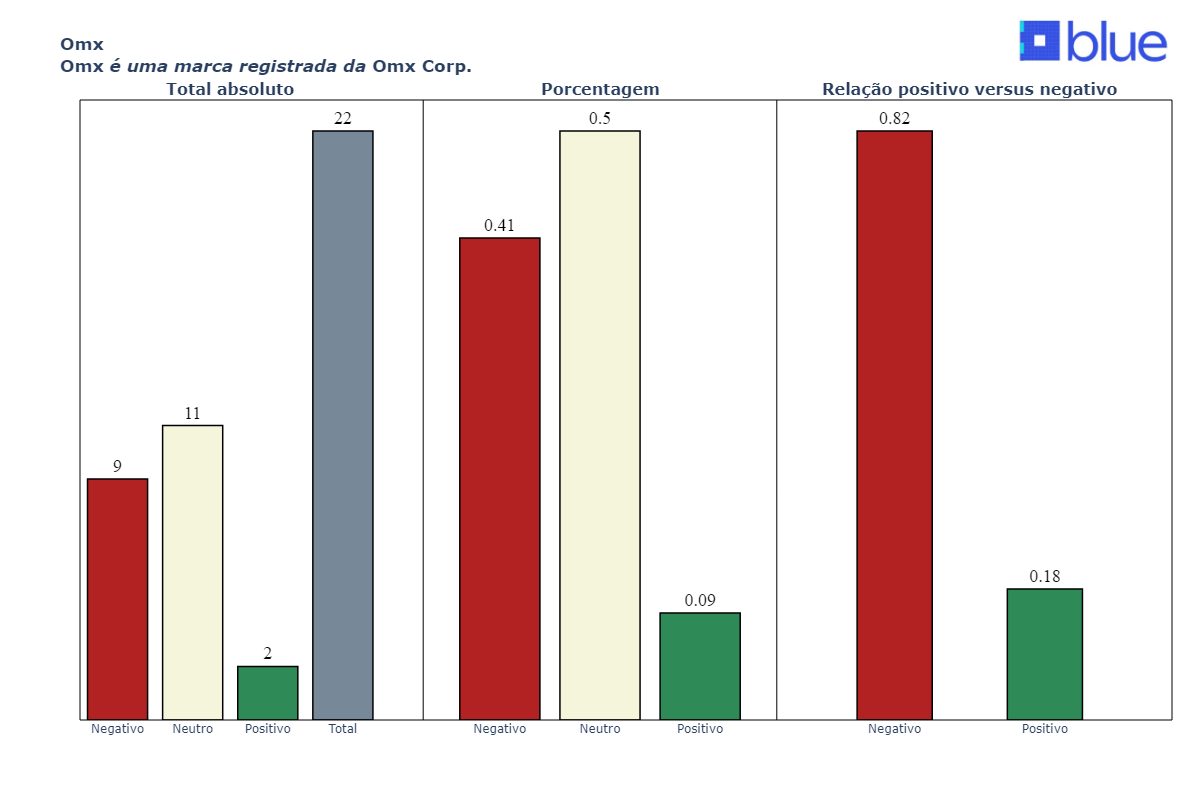

In [27]:
grafico('omx')

&nbsp;&nbsp;&nbsp;&nbsp;A OMX está muito mal falada nas redes sociais, existem apenas 2 comentários positivos dentro de uma amostra de 22 comentários, mesmo que a maioria seja comentários neutros, a quantidade de comentários negativos versus positivos está muito desproporcional.

&nbsp;&nbsp;&nbsp;&nbsp;Em relação a nokia, os comentários negativos significam apenas pequenas quedas nos faturamentos da nokia e comparativos com grandes empresas tipo Apple, os comentários neutros mostram bastante sobre algum comentário ou alguma notícia sobre a nokia, principalmente as noticiais, pois, são informações que tem o caracter neutro e as positivas são comentários que a nokia está dominando alguns mercados, tipo o de handset, subida de ações e investimentos. 

&nbsp;&nbsp;&nbsp;&nbsp;A tesco tem a sua maioria dos comentários negativos falando que suas ações caíram e sobre algumas ações que foram mal vistas da empresa, todavia existem comentários irônicos sobre a capacidade de a empresa de subir suas ações. Existem poucos comentários neutros, são apenas algumas movimentações feitas pela empresa, pode-se dizer até que são estampas de noticias e os comentários positivos abordam sobre a liderança da empresa sobre o mercado de vendas.

&nbsp;&nbsp;&nbsp;&nbsp;Sobre a OMX, quase todos os comentários negativos estão acerca da queda de ações e sobre comparação de concorrentes, os comentários neutros seguem a mesma linha dos passados, a maioria dos comentários é sobre notícias e os comentários positivos são sobre alguns rendimentos positivos que a empresa conseguiu.